In [26]:
#
# Solution by Firedrake FEM-CG of a Poisson equatiom
#
import matplotlib.pyplot as plt
import numpy as np
from firedrake import *
from firedrake.pyplot import tricontourf


testp=[1,2,3,4]
no_p=len(testp)
testres=[16,20,50,100,200,500]
no_r=len(testres)
L2_1_array=np.zeros([no_r,no_p])
L2_2_array=np.zeros([no_r,no_p])
L2_array=np.zeros([no_r,no_p])
j=0

for r in testres:
    i=0
    nx = ny = r # Try various mesh resolutions, starting coarse, say 16x16 etc.

    mesh = UnitSquareMesh(nx,ny,quadrilateral=True)
    # Quadrilateral regular mesh made: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
    # Alternatively use gmsh: 
    for p in testp:
        V = FunctionSpace(mesh, 'CG', p) # Piecewise linear continuous Galerkin function space or polynomials
        # See: https://www.firedrakeproject.org/variational-problems.html

        #
        # Method 1: construct the weak form manually by multiplying and manipulating the Poisson equation and solve the linear system
        #
        u = TrialFunction(V) # The unknown or variable u(x,y)
        v = TestFunction(V)  # The testfunction of u, which may be better called delu or deltau

        x, y = SpatialCoordinate(mesh) # Mesh coordinates

        f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)

        a = (inner(grad(u),grad(v)))*dx # Step 2/3: The weak form first term
        L = (f*v)*dx # Step 2/3: The weak form second term; dx is the infinitesimal piece in the damain here: dx*dy=dA with area A.

        u_1 = Function(V, name='u_1') # Name of solution for first method

        bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed 
        bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed 
        # See: https://www.firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC
        # The homogeneous Neumann boundary conditions are "automatically" included, i.e. do not need anything explicit

        solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0,bc_x1]) # Step 4: the solution assigned to u1

        #
        # Method 2: generate the weak form via "derivative()" of the Ritz-Galerkin integral or variational principle and solve the nonlinear system
        #
        u_2 = Function(V, name='u_2') # Name of solution for first method

        Ju = (0.5*inner(grad(u_2),grad(u_2)) - u_2*f)*dx # f->ULF? Step 2

        F = derivative(Ju, u_2, du=v) # Step 2/3: The weak form generated

        solve(F == 0, u_2, bcs=[bc_x0, bc_x1]) # Step 4: the solution assigned to u2

        # 
        # Post-processing: Use Paraview to visualise
        # See https://www.firedrakeproject.org/visualisation.html#creating-output-files
        outfile = VTKFile('output.pvd')
        outfile.write(u_1, u_2)

        f.interpolate(sin(pi*x)*cos(pi*y))
        L2_1 = sqrt(assemble(dot(u_1 - f, u_1 - f) * dx)) # L2 error solution u1
        L2_2 = sqrt(assemble(dot(u_2 - f, u_2 - f) * dx)) # L2 error solution u2
        L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx)) # L2 error difference
        L2_1_array[j,i]=L2_1
        L2_2_array[j,i]=L2_2
        L2_array[j,i]=L2
        i=i+1
        #print(f'Mesh resolution: Δx = {1/nx}')
        #print(f'L2 error: Method1 = {L2_1}, Method2 = {L2_2}')
        #print(f'L2 norm between the two results: {L2}')
    j=j+1


        




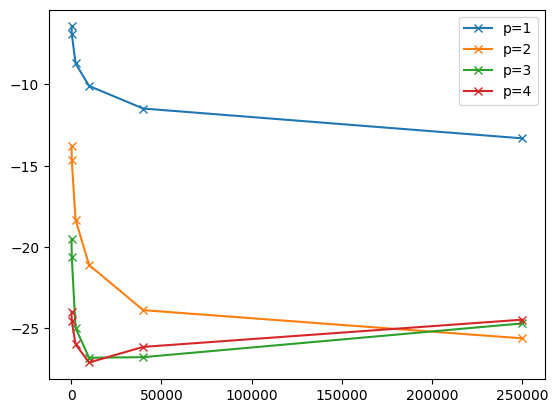

In [27]:
import matplotlib.pyplot as plt
plt.plot(np.square(testres),np.log(L2_1_array[:,0]),marker='x',label='p=1')
plt.plot(np.square(testres),np.log(L2_1_array[:,1]),marker='x',label='p=2')
plt.plot(np.square(testres),np.log(L2_1_array[:,2]),marker='x',label='p=3')
plt.plot(np.square(testres),np.log(L2_1_array[:,3]),marker='x',label='p=4')
plt.legend()

In [18]:
print(L2_1_array)

[[1.59301077e-03 1.04272520e-06 3.38214033e-09 3.86391263e-11]
 [1.02260027e-03 4.27436803e-07 1.10754865e-09 2.16968787e-11]
 [1.64352757e-04 1.09552536e-08 1.43334830e-11 5.21798317e-12]]
